In [37]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [38]:
data = pd.read_csv("for_students/weather_data.csv")
data.replace(np.nan, 0, inplace=True)
data

,temp,dew_point,feels_like,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,DATETIME
0,12.170,7.6800,11.3700,1019.0,74.0,3.3000,0.00,0.00,100.00,2018-10-01 00:00:00
1,11.995,7.6075,11.1925,1019.0,74.5,3.2625,0.00,0.00,99.25,2018-10-01 00:15:00
2,11.820,7.5350,11.0150,1019.0,75.0,3.2250,0.00,0.00,98.50,2018-10-01 00:30:00
3,11.645,7.4625,10.8375,1019.0,75.5,3.1875,0.00,0.00,97.75,2018-10-01 00:45:00
4,11.470,7.3900,10.6600,1019.0,76.0,3.1500,0.00,0.00,97.00,2018-10-01 01:00:00
...,...,...,...,...,...,...,...,...,...,...
135928,18.730,14.2100,18.6200,1010.0,75.0,1.5500,1.77,1.48,100.00,2022-08-16 22:00:00
135929,18.580,15.0700,18.5975,1010.0,80.5,1.5500,1.77,1.48,100.00,2022-08-16 22:15:00
135930,18.430,15.9300,18.5750,1010.0,86.0,1.5500,1.77,1.48,100.00,2022-08-16 22:30:00
135931,18.280,16.7900,18.5525,1010.0,91.5,1.5500,1.77,1.48,100.00,2022-08-16 22:45:00


In [39]:
dates = data["DATETIME"]

data.drop("DATETIME", axis=1, inplace=True)
normalized_df=(data-data.mean())/data.std()

normalized_df

,temp,dew_point,feels_like,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all
0,-0.011401,-0.100355,0.048382,0.188491,-0.293687,-0.215840,-0.901955,-1.029083,0.999991
1,-0.035695,-0.113847,0.026978,0.188491,-0.264839,-0.236464,-0.901955,-1.029083,0.980330
2,-0.059988,-0.127339,0.005575,0.188491,-0.235991,-0.257088,-0.901955,-1.029083,0.960668
3,-0.084282,-0.140832,-0.015829,0.188491,-0.207143,-0.277713,-0.901955,-1.029083,0.941007
4,-0.108576,-0.154324,-0.037232,0.188491,-0.178295,-0.298337,-0.901955,-1.029083,0.921346
...,...,...,...,...,...,...,...,...,...
135928,0.899273,1.114887,0.922611,-0.764610,-0.235991,-1.178300,3.517909,2.922538,0.999991
135929,0.878449,1.274935,0.919898,-0.764610,0.081338,-1.178300,3.517909,2.922538,0.999991
135930,0.857626,1.434982,0.917185,-0.764610,0.398667,-1.178300,3.517909,2.922538,0.999991
135931,0.836803,1.595029,0.914472,-0.764610,0.715996,-1.178300,3.517909,2.922538,0.999991


In [40]:
pca = PCA()
pca.fit(normalized_df)

PCA()

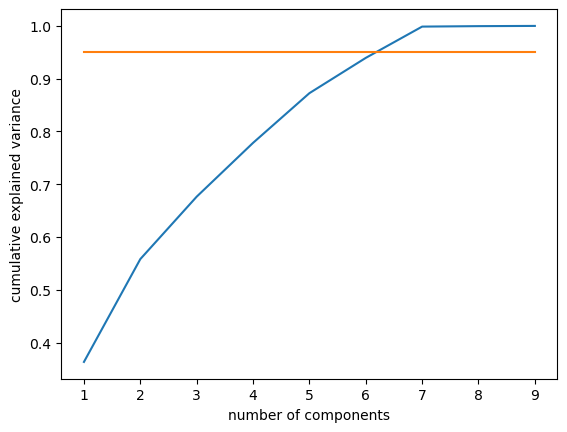

In [41]:
explained_variance = pca.explained_variance_ratio_
plt.plot(range(1, len(normalized_df.columns)+1), np.cumsum(explained_variance))
plt.plot(range(1, len(normalized_df.columns)+1), 0.95*np.ones(len(normalized_df.columns)))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

we choose 6 components instead of 9 components

In [42]:
pca = PCA(n_components=6)
pca.fit(normalized_df)
pca_data = pca.transform(normalized_df)
pca_data = pd.DataFrame(pca_data, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6"])
pca_data

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.324142,-0.087455,-0.013169,-1.467730,0.366907,0.715506
1,-0.362208,-0.100704,-0.032672,-1.453783,0.369482,0.689918
2,-0.400275,-0.113954,-0.052176,-1.439836,0.372058,0.664330
3,-0.438342,-0.127203,-0.071680,-1.425889,0.374634,0.638742
4,-0.476408,-0.140452,-0.091184,-1.411942,0.377210,0.613154
...,...,...,...,...,...,...
135928,2.630944,1.766406,-2.034894,3.282331,-0.597431,0.840209
135929,2.582707,1.890758,-2.246960,3.249395,-0.547860,0.681886
135930,2.534469,2.015110,-2.459025,3.216460,-0.498288,0.523564
135931,2.486231,2.139463,-2.671091,3.183524,-0.448717,0.365241


In [43]:
pca_data["DATETIME"] = dates
pca_data

,PC1,PC2,PC3,PC4,PC5,PC6,DATETIME
0,-0.324142,-0.087455,-0.013169,-1.467730,0.366907,0.715506,2018-10-01 00:00:00
1,-0.362208,-0.100704,-0.032672,-1.453783,0.369482,0.689918,2018-10-01 00:15:00
2,-0.400275,-0.113954,-0.052176,-1.439836,0.372058,0.664330,2018-10-01 00:30:00
3,-0.438342,-0.127203,-0.071680,-1.425889,0.374634,0.638742,2018-10-01 00:45:00
4,-0.476408,-0.140452,-0.091184,-1.411942,0.377210,0.613154,2018-10-01 01:00:00
...,...,...,...,...,...,...,...
135928,2.630944,1.766406,-2.034894,3.282331,-0.597431,0.840209,2022-08-16 22:00:00
135929,2.582707,1.890758,-2.246960,3.249395,-0.547860,0.681886,2022-08-16 22:15:00
135930,2.534469,2.015110,-2.459025,3.216460,-0.498288,0.523564,2022-08-16 22:30:00
135931,2.486231,2.139463,-2.671091,3.183524,-0.448717,0.365241,2022-08-16 22:45:00


In [44]:
pca_data.to_csv("weather_pca_data.csv", index=False)